imports

In [3]:
import numpy as np
import gymnasium as gym
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
def calculate_bins(lower_bounds, upper_bounds, number_of_bins):
    '''
    numpy.linspace: Returns num evenly spaced samples, calculated over the interval [start, stop]
    numpy.linspace(start, stop, num=50)

    '''    
    cart_position_lower_bound = lower_bounds[0] 
    cart_veloctiy_lower_bound = lower_bounds[1] 
    pole_angle_lower_bound = lower_bounds[2] 
    pole_angular_velocity_lower_bound = lower_bounds[3] 
    
    cart_position_upper_bound = upper_bounds[0] 
    cart_velocity_upper_bound = upper_bounds[1] 
    pole_angle_upper_bound = upper_bounds[2] 
    pole_angular_velocity_upper_bound = upper_bounds[3] 
    
    cart_position_number_of_bins = number_of_bins[0] 
    cart_velocity_number_of_bins = number_of_bins[1] 
    pole_angle_number_of_bins = number_of_bins[2] 
    pole_angular_velocity_number_of_bins = number_of_bins[3] 

    global cart_position_bin
    global cart_velocity_bin
    global pole_angle_bin
    global pole_angular_velocity_bin

    # numpy.linspace(start, stop, num=50) 
    # numpy.linspace: Returns num evenly spaced samples, calculated over the interval [start, stop]
    # https://numpy.org/doc/stable/reference/generated/numpy.linspace.html
    cart_position_bin = np.linspace(cart_position_lower_bound, cart_position_upper_bound, cart_position_number_of_bins)
    cart_velocity_bin = np.linspace(cart_veloctiy_lower_bound, cart_velocity_upper_bound, cart_velocity_number_of_bins)
    pole_angle_bin = np.linspace(pole_angle_lower_bound, pole_angle_upper_bound, pole_angle_number_of_bins)
    pole_angular_velocity_bin = np.linspace(pole_angular_velocity_lower_bound, pole_angular_velocity_upper_bound, pole_angular_velocity_number_of_bins)
    # returns evenly spaced bins for cart_position, cart_velocity, pole_angle & pole_angle_velocity
    # return [cart_position_bin, cart_veloctiy_bin, pole_angle_bin, pole_angle_velocity_bin]

In [5]:
def calculate_state_index(state):
    cart_position = state[0]
    cart_velocity = state[1]
    pole_angle = state[2]
    pole_angular_velocity = state[3]

    # numpy.digitize(x, bins, right=False)
    # Return the indices of the bins to which each value in input array belongs.
    # https://numpy.org/doc/stable/reference/generated/numpy.digitize.html
    cart_position_index = np.maximum(np.digitize(cart_position, cart_position_bin)-1, 0)
    cart_velocity_index = np.maximum(np.digitize(cart_velocity, cart_velocity_bin)-1, 0)
    pole_angle_index = np.maximum(np.digitize(pole_angle, pole_angle_bin)-1, 0)
    pole_angular_velocity_index = np.maximum(np.digitize(pole_angular_velocity, pole_angular_velocity_bin)-1, 0)

    return tuple([cart_position_index, cart_velocity_index, pole_angle_index, pole_angular_velocity_index])

In [6]:
def calculate_action(episode_count, action_number, epsilon, q_matrix, current_state_index):
    # generates a random number from [0.0, 1.0)
    # used to determine epsilon greedy approach
    # https://aleksandarhaber.com/explanation-and-python-implementation-of-on-policy-sarsa-temporal-difference-learning-reinforcement-learning-tutorial/
    random_number = np.random.random()

    if episode_count < 500 or random_number < epsilon:
        return np.random.choice(action_number)

    else:
        return np.random.choice(np.where(q_matrix[current_state_index] == 
                                         np.max(q_matrix[current_state_index]))[0])

In [7]:
def simulate_episodes(number_of_episodes, env, epsilon, number_of_actions, q_matrix, gamma, alpha):
    all_episodes_reward = []

    for episode_count in tqdm(range(number_of_episodes)):
        episode_reward = []
        current_state, _ = env.reset()
        current_state = list(current_state)
        # print(f"Episode Count: {episode_count}") # debug
        
        if episode_count > number_of_episodes//2:
            epsilon = 0.999 * epsilon

        terminated = False
        while not terminated:
            current_state_index = calculate_state_index(current_state)
            # print(epsilon) # debug
            action = calculate_action(episode_count, number_of_actions, epsilon, q_matrix, current_state_index)
            next_state, reward, terminated, _, _ = env.step(action)
            episode_reward.append(reward)
            next_state = list(next_state)
            next_state_index = calculate_state_index(next_state)
            q_max = np.max(q_matrix[next_state_index])

            # calculate error
            if not terminated:
                error = reward + gamma * q_max - q_matrix[current_state_index + (action,)]
            else:
                error = reward - q_matrix[current_state_index + (action,)]

            # update Q value
            q_matrix[current_state_index + (action,)] += alpha * error
            current_state = next_state

        # print(f"Episode Reward: {np.sum(episode_reward)}") # debug
        all_episodes_reward.append(np.sum(episode_reward))
    
    return all_episodes_reward, q_matrix             

In [8]:
env = gym.make('CartPole-v1')
state, _ = env.reset()

# here define the parameters for state discretization
upper_bounds = env.observation_space.high
lower_bounds = env.observation_space.low
cart_velocity_min = -3
cart_velocity_max = 3
pole_angular_velocity_min = -10
pole_angular_velocity_max = 10
lower_bounds[1] = cart_velocity_min
upper_bounds[1] = cart_velocity_max
lower_bounds[3] = pole_angular_velocity_min
upper_bounds[3] = pole_angular_velocity_max

cart_position_number_of_bins = 30
cart_velocity_number_of_bins = 30
pole_angle_number_of_bins = 30
pole_angular_velocity_number_of_bins = 30
number_of_bins = [cart_position_number_of_bins, cart_velocity_number_of_bins, pole_angle_number_of_bins, pole_angular_velocity_number_of_bins]
calculate_bins(lower_bounds, upper_bounds, number_of_bins)
print(cart_position_bin) # debug
print(cart_velocity_bin) # debug
print(pole_angle_bin) # debug
print(pole_angular_velocity_bin) # debug


[-4.80000019 -4.46896569 -4.1379312  -3.8068967  -3.47586221 -3.14482771
 -2.81379322 -2.48275872 -2.15172422 -1.82068973 -1.48965523 -1.15862074
 -0.82758624 -0.49655174 -0.16551725  0.16551725  0.49655174  0.82758624
  1.15862074  1.48965523  1.82068973  2.15172422  2.48275872  2.81379322
  3.14482771  3.47586221  3.8068967   4.1379312   4.46896569  4.80000019]
[-3.         -2.79310345 -2.5862069  -2.37931034 -2.17241379 -1.96551724
 -1.75862069 -1.55172414 -1.34482759 -1.13793103 -0.93103448 -0.72413793
 -0.51724138 -0.31034483 -0.10344828  0.10344828  0.31034483  0.51724138
  0.72413793  0.93103448  1.13793103  1.34482759  1.55172414  1.75862069
  1.96551724  2.17241379  2.37931034  2.5862069   2.79310345  3.        ]
[-0.41887903 -0.38999082 -0.36110261 -0.3322144  -0.3033262  -0.27443799
 -0.24554978 -0.21666157 -0.18777336 -0.15888515 -0.12999694 -0.10110873
 -0.07222052 -0.04333231 -0.0144441   0.0144441   0.04333231  0.07222052
  0.10110873  0.12999694  0.15888515  0.18777336 

In [9]:
current_state_index = calculate_state_index(state)
print(state[0])
print(state[1])
print(state[2])
print(state[3])
print(current_state_index) # debug

0.027378282
-0.04463954
0.011101854
0.0016231806
(14, 14, 14, 14)


In [10]:
number_of_actions = env.action_space.n
epsilon = 0.2
q_matrix = np.random.uniform(low=0, high=1, size=(cart_position_number_of_bins, cart_velocity_number_of_bins, pole_angle_number_of_bins, pole_angular_velocity_number_of_bins, number_of_actions))

action = calculate_action(1000, number_of_actions, epsilon, q_matrix, current_state_index)
# print(action) # debug

In [11]:
number_of_episodes = 15000
gamma = 1
alpha = 0.1
all_episodes_reward, updated_q_matrix = simulate_episodes(number_of_episodes, env, epsilon, number_of_actions, q_matrix, gamma, alpha)

100%|██████████| 15000/15000 [08:36<00:00, 29.07it/s]


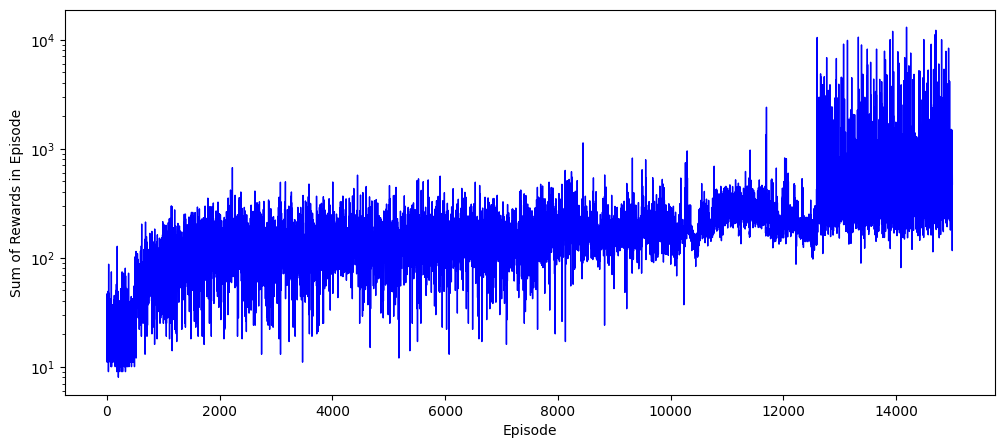

In [12]:
plt.figure(figsize=(12, 5))
# plot the figure and adjust the plot parameters
plt.plot(all_episodes_reward, color='blue', linewidth=1)
plt.xlabel('Episode')
plt.ylabel('Sum of Rewards in Episode')
plt.yscale('log')   
# plt.savefig('convergence.png')
plt.show()

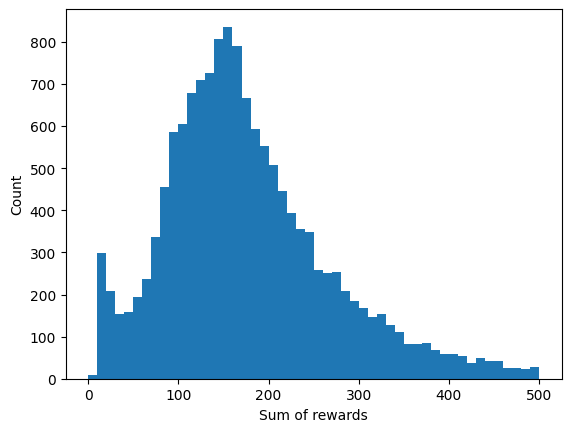

In [13]:
plt.hist(all_episodes_reward, bins=50, range=(0,500))
plt.xlabel('Sum of rewards')
plt.ylabel('Count')
plt.show()

In [16]:
def calculate_greedy_action(q_matrix, current_state_index):
    action = np.random.choice(np.where(q_matrix[current_state_index] 
                                       == np.max(q_matrix[current_state_index]))[0])
    
    return action

def simulate_learned_strategy(q_matrix):
    env = gym.make('CartPole-v1', render_mode='human')
    current_state, _ = env.reset()
    env.render()
    total_rewards = []
    terminated = False
    while not terminated:
        current_state_index = calculate_state_index(current_state)
        action = calculate_greedy_action(q_matrix, current_state_index)
        next_state, reward, terminated, _, _ = env.step(action)
        total_rewards.append(reward)
        current_state = next_state
        time.sleep(0.05)

    time.sleep(1)
    env.close()
    
    return total_rewards

total_rewards = simulate_learned_strategy(updated_q_matrix)
print(np.sum(total_rewards))


353.0
